

<h1 align=center><font size = 5>Credit Card Fraud Detection </font></h1>

This project concerns credit card fraud and is intended to look at the purchase dataset and determine whether or not it is fraudulent.

In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn

In [2]:
#importing data
data = pd.read_csv('creditcard.csv')

In [3]:
#exploring dataset
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [4]:
data.shape

(284807, 31)

In [5]:
# random_state helps assure that you always get the same output for splitting the data
# it helps create usable outcomes and it does not matter what the number is
# frac is percentage of the data that will be returned
data = data.sample(frac = 0.2, random_state = 1)
print(data.shape)

(56961, 31)


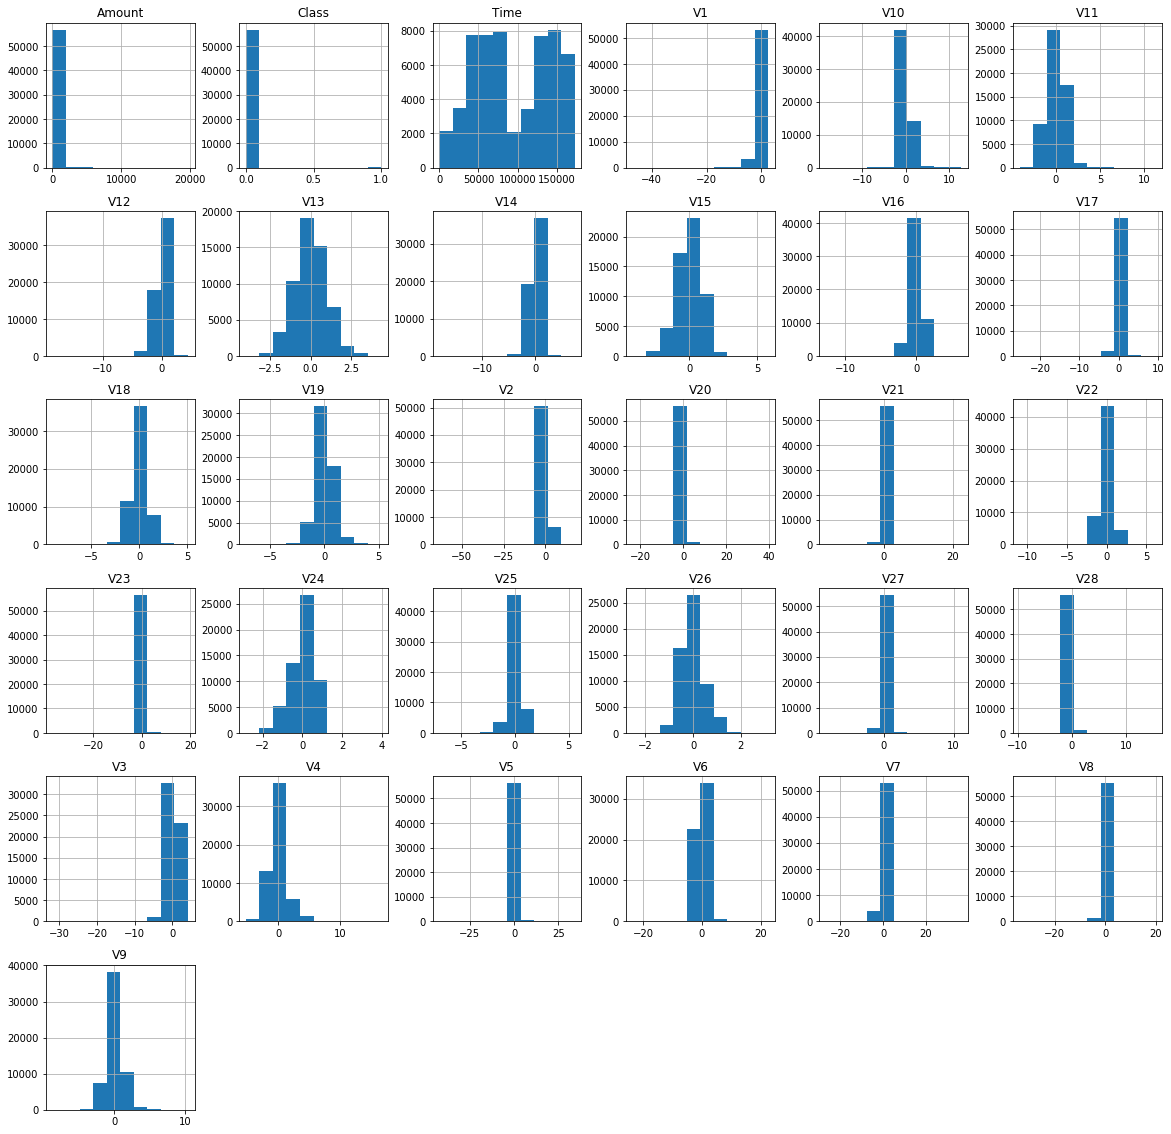

In [6]:
# plotting the histogram of each parameter
data.hist(figsize = (20, 20))
plt.show()

You can see most of the V's are clustered around 0 with some or no outliers. Notice we have very few fraudulent cases over valid cases in our class histogram.

In [7]:
# determining the number of fraud cases
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]

outlier_fraction = len(fraud) / float(len(valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(fraud)))
print('Valid Cases: {}'.format(len(valid)))

0.0015296972254457222
Fraud Cases: 87
Valid Cases: 56874


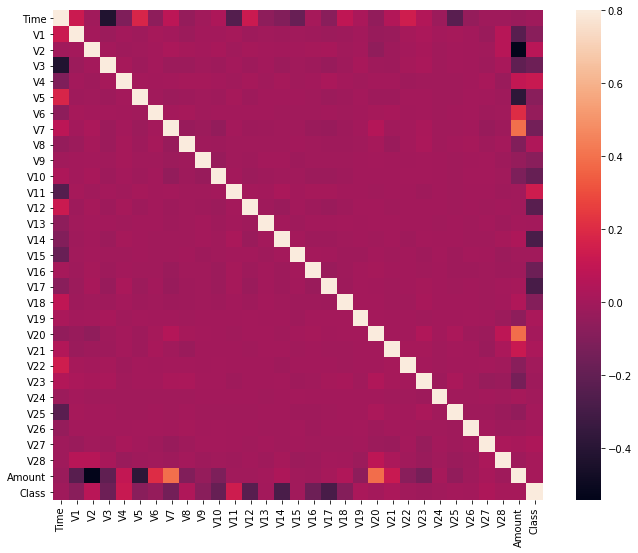

In [8]:
# correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

You can see that there are many values close to 0. Most are fairly unrelated. The squares are lighter and mean a stronger correlation.

In [9]:
#organizing data

# getting the columns from the dataframe
columns = data.columns.tolist()

# filtering the columns to remove the data we do not want
columns = [c for c in columns if c not in ['Class']]

# storing the variable we will be predicting on which is class
target = 'Class'

# X includes everything except our class column
X = data[columns]
# Y includes all the class labels for each sample
# this is also one-dimensional
Y = data[target]

# printing the shapes of X and Y
print(X.shape)
print(Y.shape)

(56961, 30)
(56961,)


In [10]:
#applying algorithms

from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [11]:
# defining a random state
state = 1

# defining the outlier detection methods
classifiers = {
    # contamination is the number of outliers we think there are
    'Isolation Forest': IsolationForest(max_samples = len(X),
                                       contamination = outlier_fraction,
                                       random_state = state),
    # number of neighbors to consider, the higher the percentage of outliers the higher you want to make this number
    'Local Outlier Factor': LocalOutlierFactor(
    n_neighbors = 20,
    contamination = outlier_fraction)
}

In [13]:
#fitting the model

n_outliers = len(fraud)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fitting the data and tag outliers
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    # reshaping the prediction values to 0 for valid and 1 for fraud
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1

    # calculating the number of errors
    n_errors = (y_pred != Y).sum()
    
    # classification matrix
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))

Isolation Forest: 129
0.9977352925685996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.26      0.26      0.26        87

    accuracy                           1.00     56961
   macro avg       0.63      0.63      0.63     56961
weighted avg       1.00      1.00      1.00     56961

Local Outlier Factor: 173
0.9969628342199048
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.01      0.01      0.01        87

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961



Finally...

Looking at the accuracy of fraudulent cases (1) allows us to know the percentage of cases properly labeled. 'Precision' represents false-positives. 'Recall' represents false-negatives. Low numbers might mean we're constantly calling customers asking them if they actually made the transaction which could be annoying.

Our Isolation Forest method (which is Random Forest based) was able to produce a better result. Looking at the **f1-score 26% (or approx. 30%)** of the time we are going to detect the fraudulent transactions.